In [1]:
# https://arxiv.org/pdf/2206.04672.pdf

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
import sklearn.preprocessing

In [4]:
# npts = 50000
npts = 5000
# npts = 500
X = np.linspace(0, 1, npts)[:,np.newaxis]

y = X * (np.sin(X*2*np.pi)+np.sin(X*2*np.pi*10))

# y += np.random.normal(0, 0.1, size=X.shape)

y += np.sin(X*2*np.pi*100)*0.1

# y = np.sin(X*2*np.pi)

# X = X - 0.5

X_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
# X_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.001, 0.001))
X = X_scaler.fit_transform(X)



Xtrain = X[::2]
ytrain = y[::2]
Xtest = X[1::2]
ytest = y[1::2]


In [5]:
X.shape

(5000, 1)

In [6]:
Xtrain.shape

(2500, 1)

In [7]:
Xtest.shape

(2500, 1)

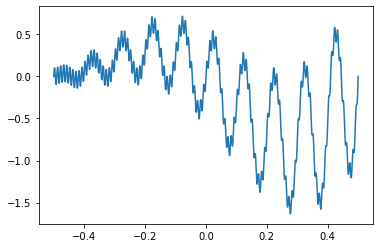

In [8]:
plt.plot(X, y)

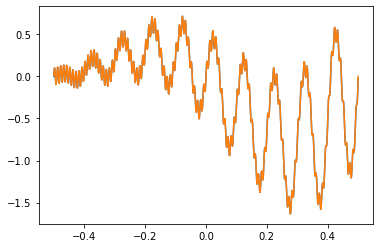

In [9]:
plt.plot(Xtrain, ytrain)
plt.plot(Xtest, ytest)

In [10]:
dx = X[1,0]-X[0,0]

In [11]:
1/dx

4998.999999999713

In [12]:
dx_train = Xtrain[1,0]-Xtrain[0,0]

In [13]:
1/dx_train

2499.4999999998563

In [14]:
f_s = 1/dx
f_s

4998.999999999713

In [15]:
f_s

4998.999999999713

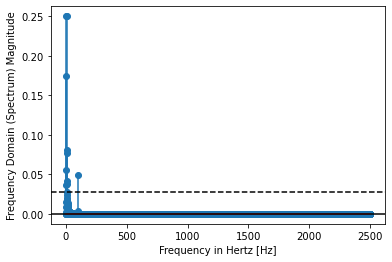

In [16]:
# frequency analysis
from scipy import fftpack

# divide by len(y) to normalise
# y_tilde = fftpack.fft(y[:,0])/len(y)
# freqs = fftpack.fftfreq(len(y)) * f_s
y_tilde = fftpack.rfft(y[:,0])/len(y)
freqs = fftpack.rfftfreq(len(y)) * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(y_tilde))
# ax.plot(freqs, np.abs(y_tilde))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
# ax.set_xlim(-f_s / 2, f_s / 2)
# ax.set_xlim(-30, 30)
# ax.set_xlim(-200, 200)
# ax.set_xlim(-5, 600)
# ax.set_ylim(-5, 110)

plt.axhline(np.percentile(np.abs(y_tilde), 95), c='k')
plt.axhline(np.percentile(np.abs(y_tilde), 99.8), c='k', ls='--')

In [17]:
np.abs(y_tilde).argmax()

2

In [18]:
np.abs(y_tilde)[1]

0.05565197488949094

In [19]:
freqs[1]

0.9997999999999425

In [20]:
np.percentile(np.abs(y_tilde), 95)

5.5012375962535275e-05

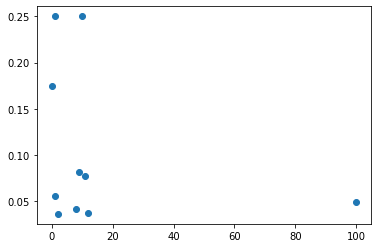

In [21]:
mask = np.abs(y_tilde) >= np.percentile(np.abs(y_tilde), 99.8)
plt.plot(freqs[mask], np.abs(y_tilde)[mask], 'o')

In [22]:
freqs[mask].argmax()

9

In [23]:
freqs[mask][freqs[mask].argmax()]

99.97999999999425

In [24]:
# nope
# b_scale = 500
# b_scale = 5000
# b_scale = 5000//2
# b_scale = (1/dx_train)/10
# yes
b_scale = 100
# b_scale = 50000
print(b_scale)
# fan_in=32
fan_in=128
# kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=b_scale/fan_in)
kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=b_scale)
bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(fan_in, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, trainable=False),
    # tf.keras.layers.Dense(fan_in),
    tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(1,)),
#     tf.keras.layers.Dense(fan_in, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

100
Metal device set to: Apple M1 Pro


2022-06-28 18:42:00.225922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-28 18:42:00.226040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               256       
                                                                 
 lambda (Lambda)             (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,409
Trainable params: 33,153
Non-trainable params: 256
_________________________________________________________________


In [26]:
X.shape

(5000, 1)

In [27]:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
    1e-3,
    # 1000,
    5,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.0,
    name=None
)

In [28]:
# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
epochs=104
batch_size=32
steps_per_epoch = len(Xtrain) // batch_size
print(steps_per_epoch)
step = np.arange(0, epochs * steps_per_epoch)
lr_ = lrs(step)

78


Text(0.5, 0, 'epoch')

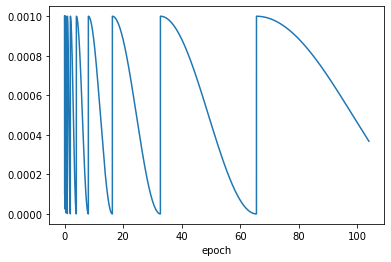

In [29]:
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")

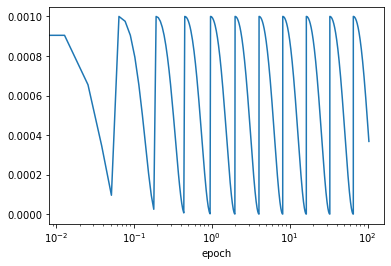

In [30]:
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.xscale('log')

Text(0.5, 0, 'iteration')

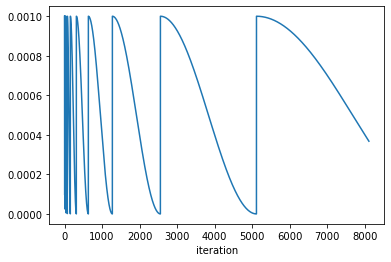

In [31]:
plt.plot(step, lr_)
plt.xlabel("iteration")

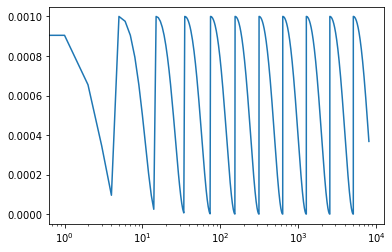

In [32]:
plt.plot(step, lr_)
plt.xscale('log')

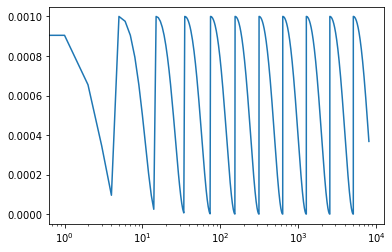

In [33]:
plt.plot(step, lr_)
plt.xscale('log')

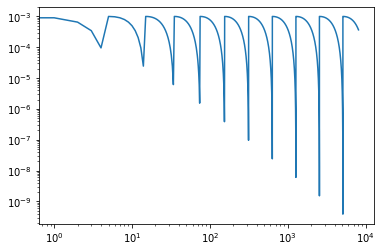

In [34]:
plt.plot(step, lr_)
plt.yscale('log')
plt.xscale('log')

In [35]:
# model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lrs))

In [36]:
model.layers[0].get_weights()[1].shape

(128,)

In [37]:
init_weights = model.layers[0].get_weights()[0][0]
init_bias = model.layers[0].get_weights()[1]

Text(0.5, 1.0, 'initial weights')

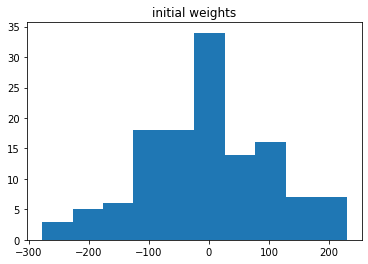

In [38]:
plt.hist(init_weights)
plt.title('initial weights')

Text(0.5, 1.0, 'initial bias')

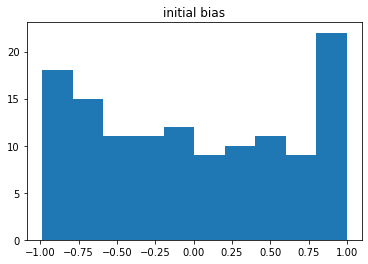

In [39]:
plt.hist(init_bias);
plt.title('initial bias')

In [40]:
%%time
# patience = epochs//50


# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
checkpoint_filepath = './checkpoint_dir/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)



# callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=patience, min_lr=1e-6)]
# callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
callbacks=[model_checkpoint_callback]
# callbacks=None
history = model.fit(Xtrain, ytrain, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=(Xtest, ytest), batch_size=batch_size)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/104


2022-06-28 18:42:01.482298: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 9/79 [==>...........................] - ETA: 0s - loss: 0.4650 

2022-06-28 18:42:01.695451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - ETA: 0s - loss: 0.1355

2022-06-28 18:42:02.477794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 13ms/step - loss: 0.1355 - val_loss: 0.0137
Epoch 2/104
79/79 [==============================] - 1s 11ms/step - loss: 0.0069 - val_loss: 0.0031
Epoch 3/104
79/79 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 4/104
79/79 [==============================] - 1s 10ms/step - loss: 9.3157e-04 - val_loss: 7.5119e-04
Epoch 5/104
79/79 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 8.9332e-04
Epoch 6/104
79/79 [==============================] - 1s 10ms/step - loss: 6.0652e-04 - val_loss: 3.3734e-04
Epoch 7/104
79/79 [==============================] - 1s 10ms/step - loss: 2.7752e-04 - val_loss: 1.8983e-04
Epoch 8/104
79/79 [==============================] - 1s 10ms/step - loss: 1.6944e-04 - val_loss: 1.7389e-04
Epoch 9/104
79/79 [==============================] - 1s 10ms/step - loss: 4.0994e-04 - val_loss: 6.2243e-04
Epoch 10/104
79/79 [==============================] - 1s 10ms/step -

In [41]:
# 1min31s

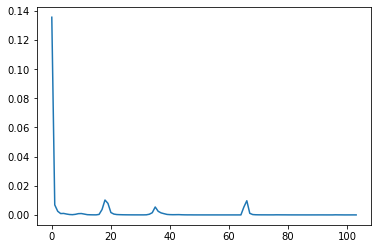

In [42]:
plt.plot(history.history['loss'])

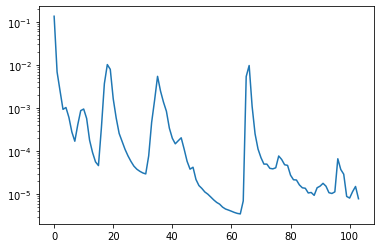

In [43]:
plt.plot(history.history['loss'])
plt.yscale('log')

In [44]:
# plt.plot(history.history['lr'])
# plt.yscale('log')

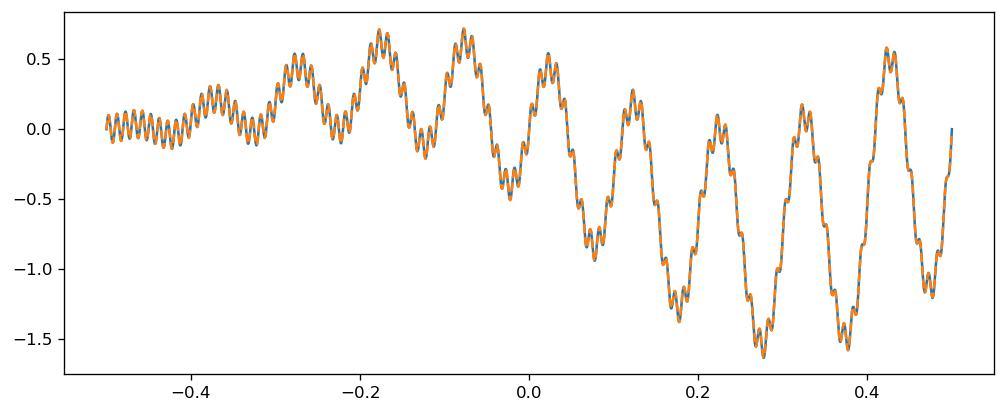

In [45]:
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(X, y)
plt.plot(X, model(X), ls='--')

(-0.5, -0.2)

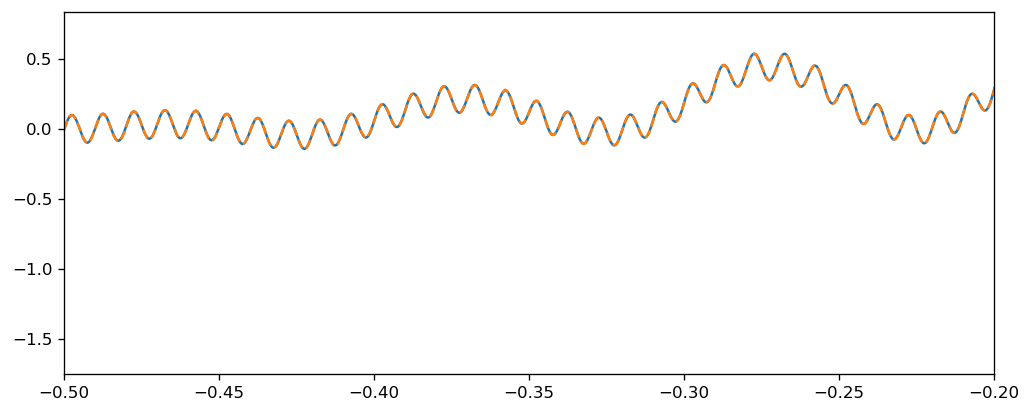

In [46]:
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(X, y)
plt.plot(X, model(X), ls='--')
plt.xlim(-0.5, -0.2)

(0.0, 0.5)

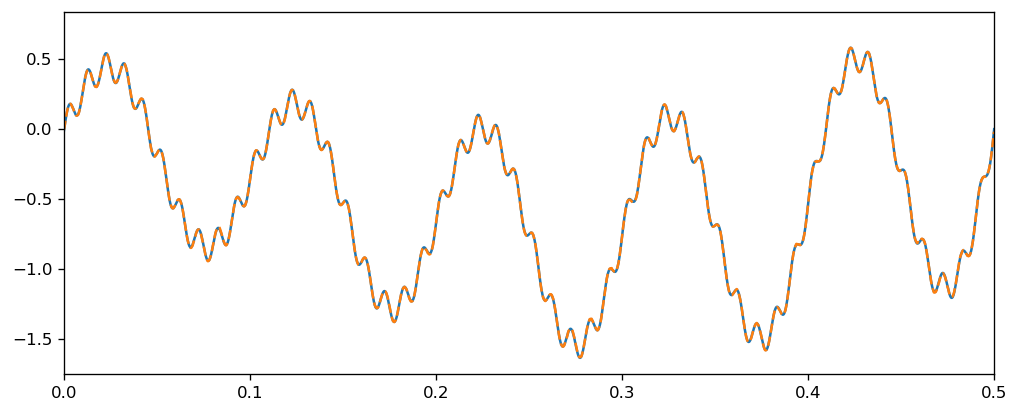

In [47]:
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(X, y)
plt.plot(X, model(X), ls='--')
plt.xlim(0, 0.5)

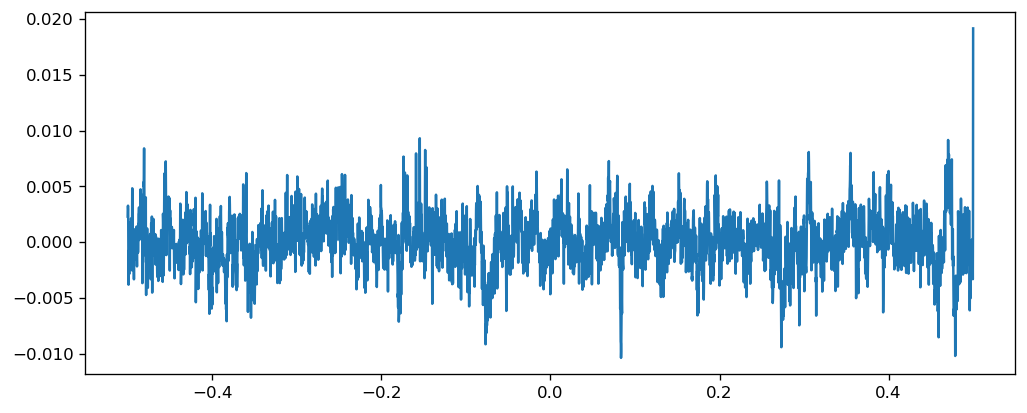

In [48]:
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(X, y-model(X))

In [49]:
final_weights = model.layers[0].get_weights()[0][0]
final_bias = model.layers[0].get_weights()[1]

Text(0.5, 1.0, 'final weights')

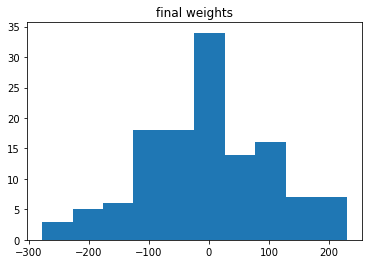

In [50]:
plt.hist(final_weights)
plt.title('final weights')

Text(0.5, 1.0, 'final bias')

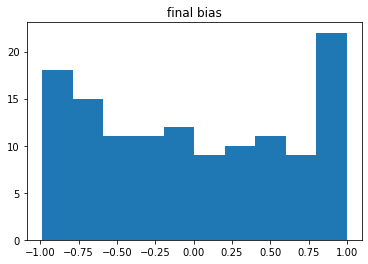

In [51]:
plt.hist(final_bias)
plt.title('final bias')

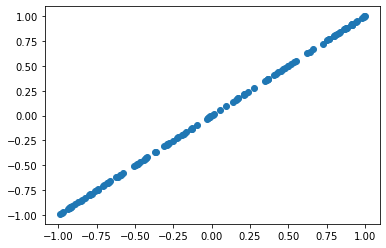

In [52]:
plt.figure()
plt.scatter(init_bias, final_bias)

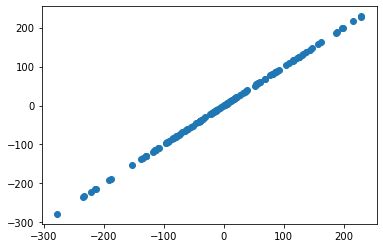

In [53]:
plt.figure()
plt.scatter(init_weights, final_weights)

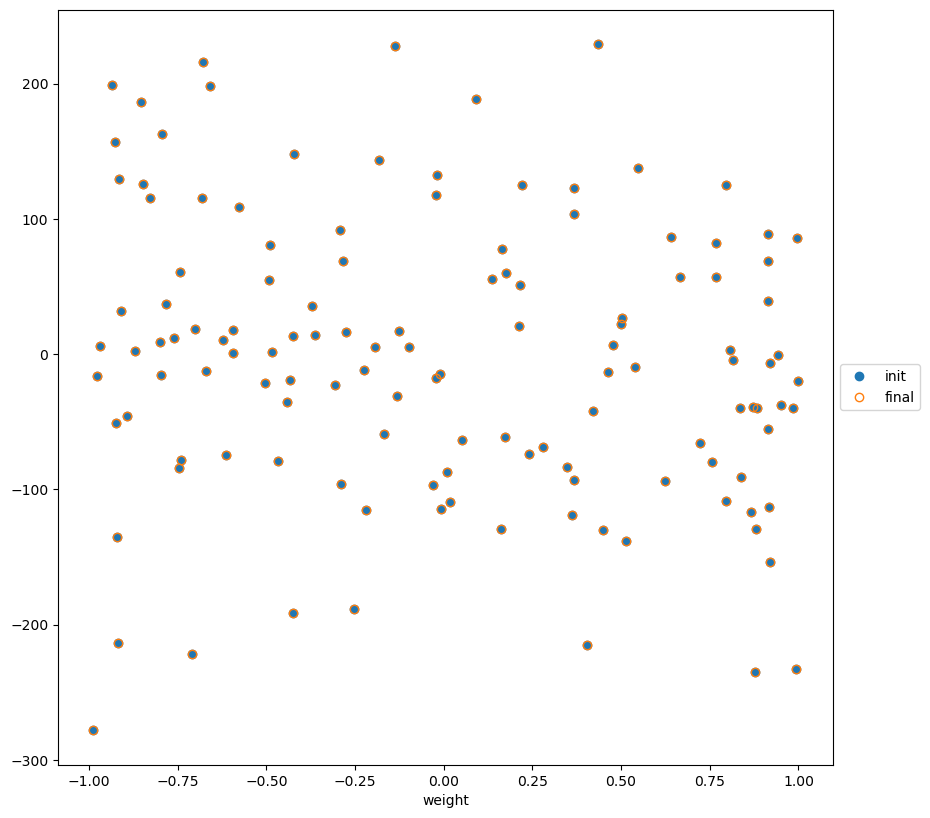

In [54]:
plt.figure(figsize=(10,10), dpi=100)
plt.plot(init_bias, init_weights, 'o', label='init')
plt.plot(final_bias, final_weights, 'o', mfc='none', label='final')

plt.xlabel('bias')
plt.xlabel('weight')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# test with waveform - compute scaled frequency

In [55]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
import lalsimulation as lalsim
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [56]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [57]:
from tf_fourier_features import FourierFeatureProjection

In [58]:
import pycbc.coordinates

In [59]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance


def MftoHz(Mf, M):
    """MftoHz(Mf, M)
    """
    return Mf / (lal.MTSUN_SI*M)

def HztoMf(Hz, M):
    """HztoMf(Hz, M)
    """
    return Hz * (lal.MTSUN_SI*M)

In [60]:
def get_ringdown_freq():
    fin_spin = phenom.remnant.FinalSpin0815(args.eta, args.chi1z, args.chi2z)
    fring = phenom.remnant.fring(args.eta, args.chi1z, args.chi2z, fin_spin)
    fdamp = phenom.remnant.fdamp(args.eta, args.chi1z, args.chi2z, fin_spin)

    finalmass = (1. - phenom.remnant.EradRational0815(args.eta, args.chi1z, args.chi2z)) * args.mtot


    print("final mass = {0} Msun".format(finalmass))
    print("ringdown frequency in geometric units = ", fring)
    print("imaginary part of the ringdown frequency = ", fdamp)
    print("ringdown frequency in Hz = ", phenom.MftoHz(fring, args.mtot))

In [1126]:
def generate_waveform(
    new_times_M,
    time_idxs=None, # indicies at which to return the data on
    mass_ratio=1,
    total_mass=100,
    spin1x=0,
    spin1y=0,
    spin1z=0,
    spin2x=0,
    spin2y=0,
    spin2z=0,
    inclination=0,
    coa_phase=0,
    approximant="SEOBNRv4_opt",
    distance_mpc=1,
    f_lower=10
):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)
    
    # https://github.com/gwastro/pycbc/blob/master/pycbc/coordinates.py#L117
    # spin1x, spin1y, spin1z = pycbc.coordinates.spherical_to_cartesian(r_1, phi_1, theta_1)

    # mass1=pycbc.conversions.mass1_from_mtotal_q(100, 4)
    # mass2=pycbc.conversions.mass2_from_mtotal_q(100, 4)

    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        # spin1x=mass_ratio,
        mass1=mass1,
        mass2=mass2,
        spin1x=spin1x,
        spin1y=spin1y,
        spin1z=spin1z,
        spin2x=spin2x,
        spin2y=spin2y,
        spin2z=spin2z,
        approximant=approximant,
        f_lower=f_lower,
        delta_t=1/4096,
        distance=distance_mpc,
        inclination=inclination,
        coa_phase=coa_phase,
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]

    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    # hc = np.imag(h)
    
    if time_idxs is not None:
        hp = hp[time_idxs]
        
    return hp
    # return hc
    # return new_amp
    # return new_phase

In [1127]:
# uniform spacing throughout
t1 = -10000
# t1 = -2000
# t1 = -200
# t1 = -5000
# t2 = 70
# t2 = 100
t2 = 120
# dt = 0.5
dt = 0.25
# dt = 1
new_times_M = np.arange(t1, t2, dt)

In [1128]:
%%time
params = dict(
    new_times_M=new_times_M,
    time_idxs=None,
    total_mass=100,
    # total_mass=50,
    approximant="SEOBNRv4P",
    distance_mpc=1,
    f_lower=8
)

params.update(
    dict(
        mass_ratio=4,
        spin1x=0.99,
        spin1y=0,
        spin1z=0.,
        spin2x=0,
        spin2y=0,
        spin2z=0,
        inclination=0,
        coa_phase=0,
    )
)

hp = generate_waveform(**params)

CPU times: user 1.13 s, sys: 15.1 ms, total: 1.14 s
Wall time: 1.14 s


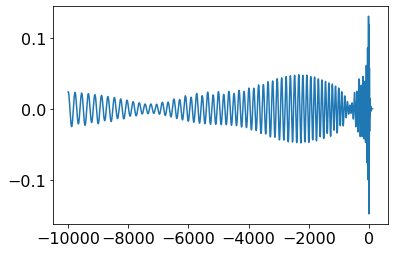

In [1129]:
plt.figure()
plt.plot(new_times_M, hp)

(-100.0, 130.0)

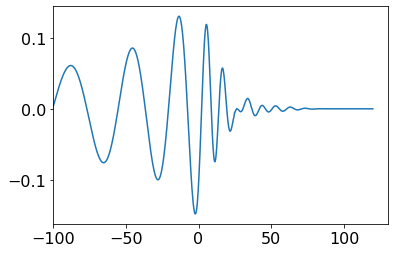

In [1130]:
plt.figure()
plt.plot(new_times_M, hp)
plt.xlim(-100, 130)

In [1131]:
mass1=pycbc.conversions.mass1_from_mtotal_q(params['total_mass'], params['mass_ratio'])
mass2=pycbc.conversions.mass2_from_mtotal_q(params['total_mass'], params['mass_ratio'])

In [1132]:
X = new_times_M[:,np.newaxis].copy()
y = hp[:,np.newaxis].copy()

In [1133]:
dx = X[1,0]-X[0,0]

In [1134]:
1/dx

4.0

In [1135]:
f_s = 1/dx
f_s

4.0

In [1136]:
pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=50, m2=50, s1z=0, s2z=0)

178.81168105047564

In [1137]:
f_rd_mf = HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=mass1, m2=mass2, s1z=params['spin1z'], s2z=params['spin2z']), params['total_mass'])
f_rd_mf

0.07443955155367343

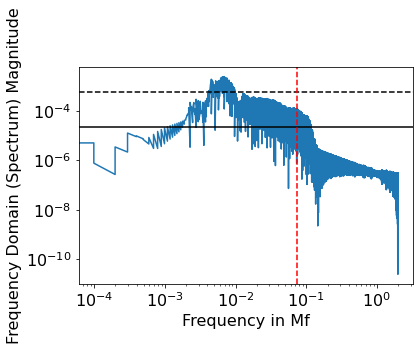

In [1138]:
# frequency analysis
from scipy import fftpack

# divide by len(y) to normalise
# y_tilde = fftpack.fft(y[:,0])/len(y)
# freqs = fftpack.fftfreq(len(y)) * f_s
y_tilde = fftpack.rfft(y[:,0])/len(y)
freqs = fftpack.rfftfreq(len(y)) * f_s

fig, ax = plt.subplots()

# ax.stem(freqs, np.abs(y_tilde))
ax.plot(freqs, np.abs(y_tilde))
ax.set_xlabel('Frequency in Mf')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
# ax.set_xlim(-f_s / 2, f_s / 2)
# ax.set_xlim(-30, 30)
# ax.set_xlim(-200, 200)
# ax.set_xlim(0, 0.2)
# ax.set_ylim(-5, 110)

plt.yscale('log')
plt.xscale('log')

plt.axhline(np.percentile(np.abs(y_tilde), 95), c='k')
plt.axhline(np.percentile(np.abs(y_tilde), 99.8), c='k', ls='--')

plt.axvline(f_rd_mf, ls='--', c='r')

In [1139]:
np.abs(y_tilde).argmax()

139

In [1140]:
np.abs(y_tilde)[1]

5.087430648680765e-06

In [1141]:
freqs[1]

9.881422924901186e-05

In [1142]:
np.percentile(np.abs(y_tilde), 95)

2.1866190436541164e-05

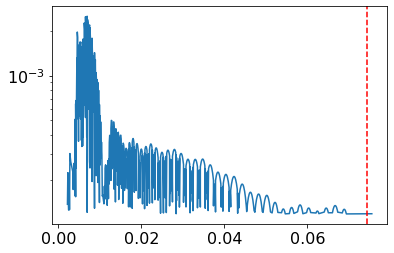

In [1143]:
mask = np.abs(y_tilde) >= np.percentile(np.abs(y_tilde), 98)
plt.plot(freqs[mask], np.abs(y_tilde)[mask], '-')

plt.axvline(f_rd_mf, ls='--', c='r')
plt.yscale('log')
# plt.xscale('log')

In [1144]:
freqs[mask].argmax()

809

In [1145]:
freqs[mask][freqs[mask].argmax()]

0.07549407114624505

In [1146]:
t_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
times_train_scaled = t_scaler.fit_transform(new_times_M[:,np.newaxis])

In [1147]:
times_train_scaled

array([[-0.5       ],
       [-0.4999753 ],
       [-0.49995059],
       ...,
       [ 0.49995059],
       [ 0.4999753 ],
       [ 0.5       ]])

In [1148]:
f_s_scaled = t_scaler.transform(np.array([[f_s]]))[0,0]
f_s_scaled

0.4885619704044072

In [1149]:
t_scaler.data_max_

array([119.75])

In [1150]:
t_scaler.data_min_

array([-10000.])

In [1151]:
t_scaler.scale_

array([9.88166704e-05])

In [1152]:
t_scaler.transform(np.array([[f_rd_mf]]))[0,0]

0.4881740595915466

In [1153]:
new_times_M[-1]

119.75

In [1154]:
t_scaler.scale_

array([9.88166704e-05])

In [1155]:
t_scaler.min_

array([0.4881667])

In [1156]:
def do_trans(x, trans):
    return (x * trans.scale_) + trans.min_

In [1157]:
def do_inv_trans(x, trans):
    return (x - trans.min_) / trans.scale_

In [1158]:
do_trans(69.9, t_scaler)

array([0.49507399])

In [1159]:
do_inv_trans(0.5, t_scaler)

array([119.75])

In [1160]:
do_trans(f_rd_mf, t_scaler)

array([0.48817406])

In [1161]:
f_s/f_s_scaled

8.187292999266807

In [1162]:
f_s

4.0

In [1163]:
f_s_scaled

0.4885619704044072

In [1164]:
f_rd_mf/(f_s/f_s_scaled)

0.009092083495770786

In [1165]:
1/(f_rd_mf/(f_s/f_s_scaled))

109.9857915366872

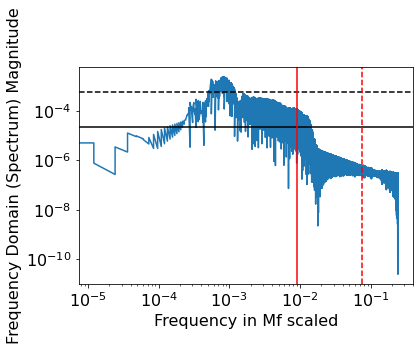

In [1166]:
# frequency analysis
from scipy import fftpack

# divide by len(y) to normalise
# y_tilde = fftpack.fft(y[:,0])/len(y)
# freqs = fftpack.fftfreq(len(y)) * f_s
y_tilde = fftpack.rfft(y[:,0])/len(y)

# freqs = fftpack.rfftfreq(len(y)) * f_s
freqs = fftpack.rfftfreq(len(y)) * f_s_scaled

fig, ax = plt.subplots()

# ax.stem(freqs, np.abs(y_tilde))
ax.plot(freqs, np.abs(y_tilde))
ax.set_xlabel('Frequency in Mf scaled')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
# ax.set_xlim(-f_s / 2, f_s / 2)
# ax.set_xlim(-30, 30)
# ax.set_xlim(-200, 200)
# ax.set_xlim(0, 0.2)
# ax.set_ylim(-5, 110)

plt.yscale('log')
plt.xscale('log')

plt.axhline(np.percentile(np.abs(y_tilde), 95), c='k')
plt.axhline(np.percentile(np.abs(y_tilde), 99.8), c='k', ls='--')

plt.axvline(f_rd_mf, ls='--', c='r')

plt.axvline(f_rd_mf/(f_s/f_s_scaled), ls='-', c='r')



# todo

- check to see if we can leave the inputs as unscaled now
- still probably should scale the output

In [1167]:
X = new_times_M[:,np.newaxis].copy()
y = hp[:,np.newaxis].copy()

In [1168]:
X.shape

(40480, 1)

In [1169]:
y.shape

(40480, 1)

In [1170]:
y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
y = y_scaler.fit_transform(y)

In [1171]:
Xtrain = X[::2]
ytrain = y[::2]
Xtest = X[1::2]
ytest = y[1::2]

In [1172]:
X

array([[-10000.  ],
       [ -9999.75],
       [ -9999.5 ],
       ...,
       [   119.25],
       [   119.5 ],
       [   119.75]])

In [1173]:
y

array([[0.11766421],
       [0.1176843 ],
       [0.11770021],
       ...,
       [0.03174531],
       [0.03173599],
       [0.03172516]])

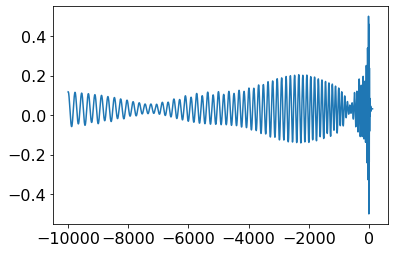

In [1174]:
plt.plot(X, y)

In [1255]:
def fit_data(Xtrain, ytrain, Xtest, ytest, b_scale=0.1, epochs=104, batch_size=32):
    fan_in=128
    # kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=b_scale/fan_in)
    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=b_scale)
    bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(fan_in, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, trainable=False),
        # tf.keras.layers.Dense(fan_in),
        tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    # model = tf.keras.Sequential([
    #     tf.keras.layers.Input(shape=(1,)),
    #     tf.keras.layers.Dense(fan_in, activation='relu'),
    #     tf.keras.layers.Dense(128, activation='relu'),
    #     tf.keras.layers.Dense(128, activation='relu'),
    #     tf.keras.layers.Dense(1)
    # ])

    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
    lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
        1e-3,
        # 1000,
        5,
        t_mul=2.0,
        m_mul=1.0,
        alpha=0.0,
        name=None
    )
    
    # https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
    # epochs=104
    # batch_size=32
    steps_per_epoch = len(Xtrain) // batch_size
    print(steps_per_epoch)
    step = np.arange(0, epochs * steps_per_epoch)
    lr_ = lrs(step)
    
    plt.figure()
    plt.plot(step/steps_per_epoch, lr_)
    plt.xlabel("epoch")
    plt.title("learning rate schedule")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
    plt.close()
    
    # model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lrs))


    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    checkpoint_filepath = './checkpoint_dir/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True)



    # callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=patience, min_lr=1e-6)]
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    callbacks=[model_checkpoint_callback]
    # callbacks=None
    history = model.fit(Xtrain, ytrain, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=(Xtest, ytest), batch_size=batch_size)

    # The model weights (that are considered the best) are loaded into the model.
    model.load_weights(checkpoint_filepath)
    
    return history, model

In [1256]:
b_scale=f_rd_mf
b_scale

0.07443955155367343

In [1257]:
Xtrain.shape

(20240, 1)

In [1237]:
%%time
# history, model = fit_data(Xtrain, ytrain, Xtest, ytest, b_scale=b_scale, epochs=126, batch_size=32
history, model = fit_data(Xtrain, ytrain, Xtest, ytest, b_scale=b_scale, epochs=126, batch_size=128)

158
Epoch 1/126
  9/159 [>.............................] - ETA: 1s - loss: 0.1733 

2022-06-28 23:57:30.092339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


159/159 [==============================] - ETA: 0s - loss: 0.0343

2022-06-28 23:57:31.210833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


159/159 [==============================] - 2s 10ms/step - loss: 0.0343 - val_loss: 0.0089
Epoch 2/126
159/159 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 3/126
159/159 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 4/126
159/159 [==============================] - 1s 9ms/step - loss: 9.2409e-04 - val_loss: 8.5319e-04
Epoch 5/126
159/159 [==============================] - 1s 9ms/step - loss: 7.4389e-04 - val_loss: 4.3375e-04
Epoch 6/126
159/159 [==============================] - 1s 9ms/step - loss: 3.8217e-04 - val_loss: 2.6823e-04
Epoch 7/126
159/159 [==============================] - 1s 9ms/step - loss: 2.5021e-04 - val_loss: 2.0427e-04
Epoch 8/126
159/159 [==============================] - 1s 9ms/step - loss: 1.9810e-04 - val_loss: 1.9408e-04
Epoch 9/126
159/159 [==============================] - 1s 9ms/step - loss: 2.6218e-04 - val_loss: 2.0162e-04
Epoch 10/126
159/159 [==============================] 

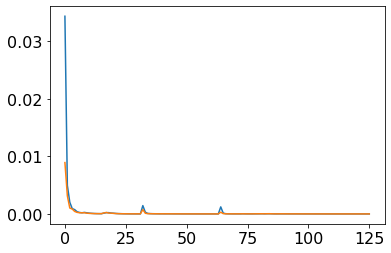

In [1238]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

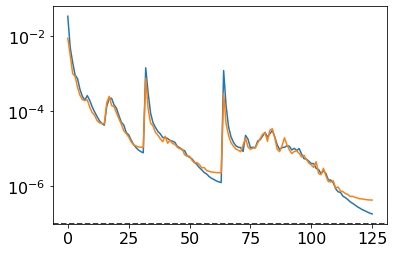

In [1239]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.axhline(1e-7, c='k', ls='--')

In [1240]:
# plt.plot(history.history['lr'])
# plt.yscale('log')

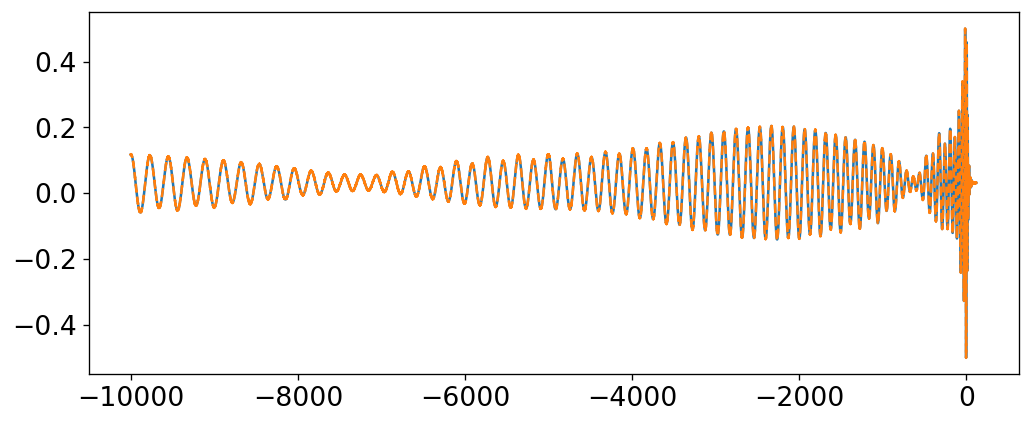

In [1241]:
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(X, y)
plt.plot(X, model(X), ls='--')

(-100.0, 130.0)

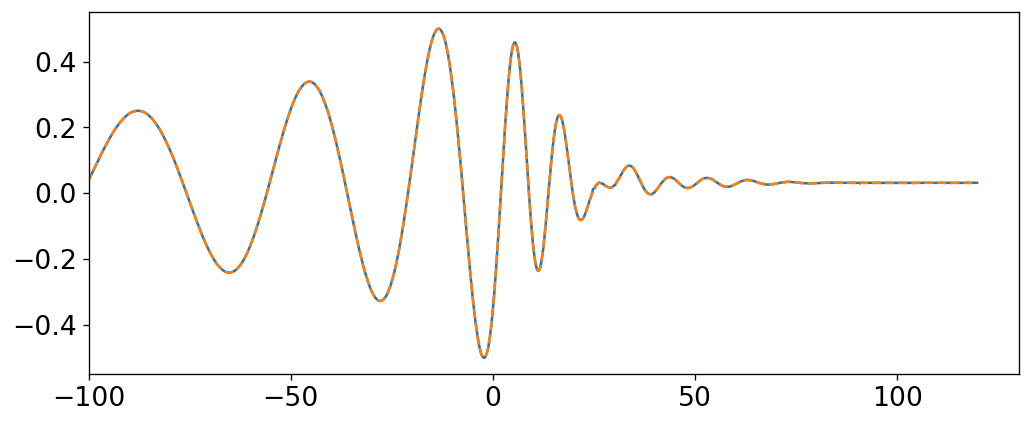

In [1247]:
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(X, y)
plt.plot(X, model(X), ls='--')
plt.xlim(-100, 130)

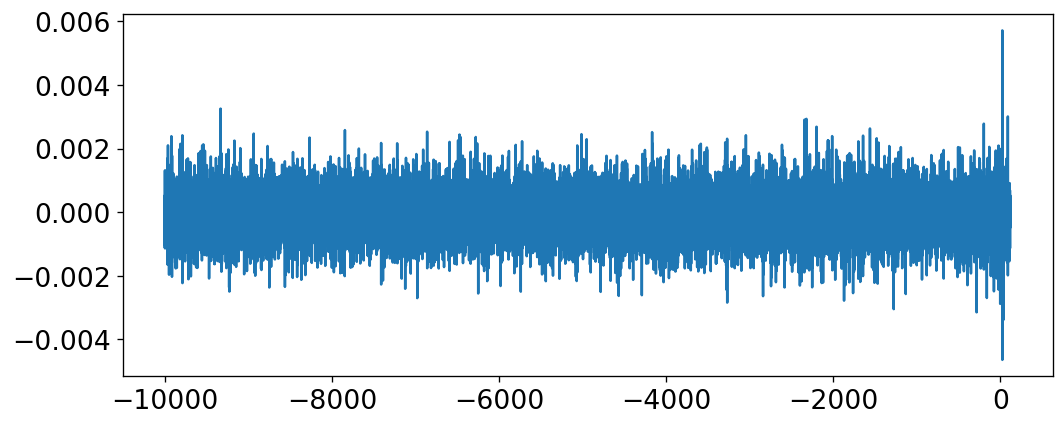

In [1243]:
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(X, y-model(X))

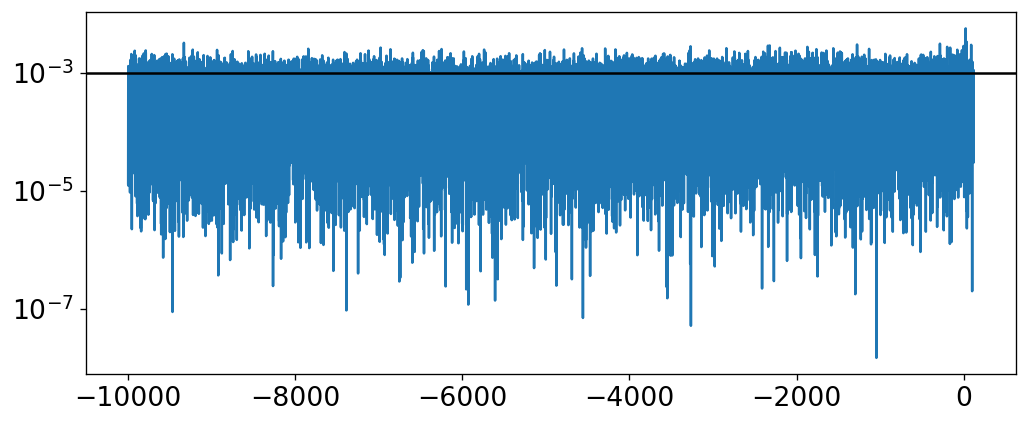

In [1244]:
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(X, np.abs(y-model(X)))
plt.yscale('log')
plt.axhline(1e-3, c='k')

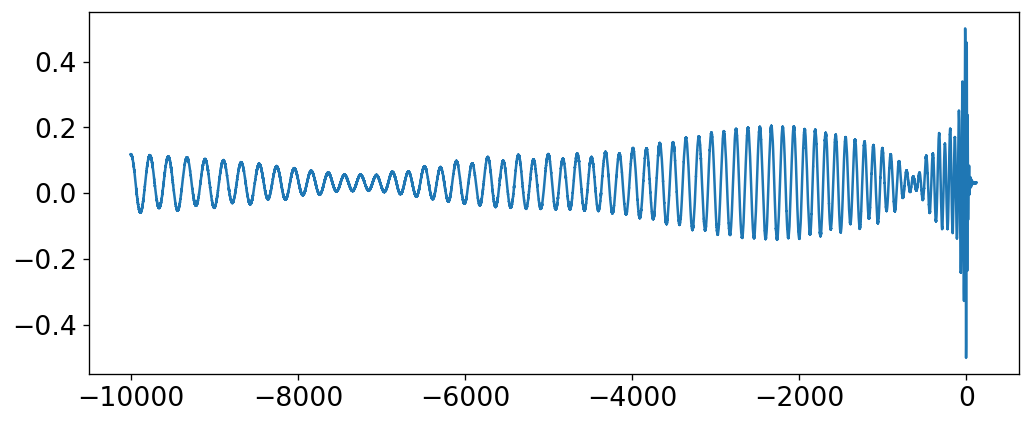

In [1245]:
X_fine = np.arange(X[0,0], X[-1,0], 0.01)
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(X_fine, model(X_fine), ls='-')
# plt.xlim(-100, 100)